In [2]:
import pandas as pd

file_path = '/Users/yukiharuta/Desktop/Temp-Data/MAPbBr3-Paper/XRD/5_Others/Si-wafer_omega400_monochromator.csv'
save_path = '/Users/yukiharuta/Desktop/Temp-Data/MAPbBr3-Paper/XRD/5_Others/Si-wafer_omega400_monochromator_NORM.csv'

# Read the CSV file into a DataFrame, skipping XX lines of headers to read it properly
skiprows = 1
while True:
    try:
        data = pd.read_csv(file_path, skiprows=skiprows)
        x = data['Angle'].to_list()
        break
    except:
        skiprows += 1
        if skiprows == 100:
            break
# Prepare x and y
y = data[' Intensity'].to_list()
# Normilize intensity
y_NORM = [n/max(y) for n in y]
index = y.index(max(y))
x_NORM = [n - x[index] for n in x]

# Create new dataframe
df = pd.DataFrame({
    'Omega (degree)': x,
    'Intensity': y,
    'NORM_omega': x_NORM,
    'NORM': y_NORM
})

# Save new csv
df.to_csv(save_path)

/var/folders/n_/_z_q62kx279gp1tfsgqh78s40000gn/T/ipykernel_83814/4269707815.py:24: RuntimeWarning: invalid value encountered in double_scalars
  y = y0 + A*(2*gamma(mu)*np.sqrt(2**(1/mu)-1))/np.sqrt(np.pi)/gamma(mu-0.5)/w*(1+4*(2**(1/mu)-1)/w/w*(x-xc)**2)**(-mu)
/var/folders/n_/_z_q62kx279gp1tfsgqh78s40000gn/T/ipykernel_83814/4269707815.py:24: RuntimeWarning: overflow encountered in double_scalars
  y = y0 + A*(2*gamma(mu)*np.sqrt(2**(1/mu)-1))/np.sqrt(np.pi)/gamma(mu-0.5)/w*(1+4*(2**(1/mu)-1)/w/w*(x-xc)**2)**(-mu)


A:16.50756566505334, w:15.77571524637928, mu:171.47955451264536, R2:0.9985825860834276


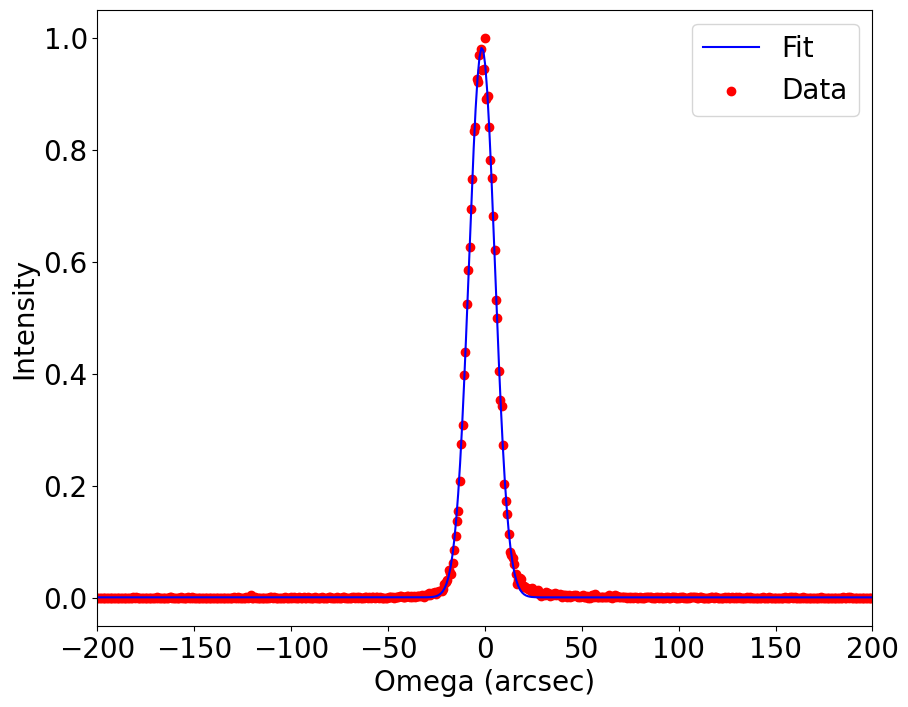

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.optimize import curve_fit
from scipy.special import wofz
from scipy.special import gamma, factorial
from sklearn.metrics import r2_score
import datetime

# Plot option
x_option = 1 #0:degree 1:arcsec
y_option = 0 #0:normalized 1:intensity

# Prepare options
xlabel = ['Omega (degree)', 'Omega (arcsec)']
yoption = ['NORM', 'Intensity']

# Prepare files for fitting
file_path = '/Users/yukiharuta/Desktop/Temp-Data/MAPbBr3-Paper/XRD/5_Others/Si-wafer_omega400_monochromator_NORM.csv'

# define the PearsonVII function
def PearsonVII(x, xc, y0, A, mu, w):
    y = y0 + A*(2*gamma(mu)*np.sqrt(2**(1/mu)-1))/np.sqrt(np.pi)/gamma(mu-0.5)/w*(1+4*(2**(1/mu)-1)/w/w*(x-xc)**2)**(-mu)
    return y

def extract_FWXM(index, xc, y0, A, mu, w):

    x_P = np.arange(0,100,0.01)
    y_P = [PearsonVII(n, xc, y0, A, mu, w) for n in x_P]
    y_P = [n/max(y_P) for n in y_P]

    index = 0.1 # Full-width at [index] maximum

    search = [abs(n-index) for n in y_P]
    FWXM = 2*x_P[search.index(min(search))]
    
    return FWXM

# Read txt files
df = pd.read_csv(file_path)
x = df['NORM_omega'].to_list()
if x_option == 1:
    x = [n*3600 for n in x]
y = df[yoption[y_option]].to_list()

# initial guess for the parameters of the first peak
xc_guess = 0
y0_guess = 0
A_guess = 30
mu_guess = 1.0
w_guess = 30

# define the range of x-values to fit over
x_min = np.min(x)
x_max = np.max(x)

# fit the Voigt function to the data
popt, pcov = curve_fit(PearsonVII, x, y, p0=[xc_guess, y0_guess, A_guess, mu_guess, w_guess])
X = np.arange(x_min,x_max,1)

# calculate R-squared value
y_fit = PearsonVII(x, *popt)
R2 = r2_score(y, y_fit)

# Prepare
y0_fit = popt[1]
xc_fit = popt[0]
A_fit = popt[2]
w_fit = popt[4]
mu_fit = popt[3]

index = 0.2
FWXM = extract_FWXM(index, xc_fit, y0_fit, A_fit, mu_fit, w_fit)

# Prepare recording values and add to the summary
print(f'A:{A_fit}, w:{w_fit}, mu:{mu_fit}, R2:{R2}')

# plot the fitted function and the data
fig = plt.figure(figsize=(10,8))
plt.rcParams["font.size"] = 20
plt.plot(X, PearsonVII(X, *popt), color='blue', label='Fit')
plt.scatter(x, y, color='red', label='Data')
plt.legend()
plt.xlabel(xlabel[x_option])
plt.ylabel('Intensity')

plt.xlim(-200,200)
plt.show()